In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib.reader import *
from lib.preprocess import *
import nltk
from sklearn.pipeline import *
from sklearn.feature_extraction.text import *
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import *
from functools import partial
from typing import *
from sklearn.model_selection import train_test_split
import re
from nltk.tree import ParentedTree
from lib.morph import *
from sklearn.compose import make_column_transformer

In [3]:
X_train = pd.read_csv("data/train.csv")

In [4]:
y_columns = [
    col for col in X_train.columns 
    if col != "Kalimat" and col != "parsed" and col != "index" and col != "Unnamed: 0" ]

Mutually exclusive classes.


# Active - Passive
sentence in active voice: Sentence which has **verb in active voice**. Or the subject is doing the action of the verb.

sentence in passive voice: Sentence which has **verb in passive voice**. Or the action is done to the subject.

References
* https://www.grammarly.com/blog/active-vs-passive-voice/ 
* https://www.grammar-monster.com/glossary/active_sentences.htm


# Transitive - Intransitive
transitive sentence.
Sentence that demands object.

intransitive sentence
Sentence that do not need object.

- need to determine whether the verb has an object.

References 
* https://www.grammarly.com/blog/transitive-and-intransitive-verbs/


# Simple - Compound
simple sentence
> has 1 independent clause.

compound sentence
> has 2 or more independent clause

complex sentence
> 1 independent clause + 1 subordinate clause

compound-complex sentence
> 2 or more independent clause + 1 subordinate clause

References
* https://www.grammarly.com/blog/sentence-structure/

# Predicate
Noun-predicate sentence

Adjective-predicate sentence

Numeral-predicate sentence


# Intonation
interrogative sentence

imperative sentence

exclamative sentence



In [5]:
y_columns

['simple sentence',
 'compound sentence',
 'complex sentence',
 'compound-complex sentence',
 'incomplete sentence',
 'transitive sentence',
 'intransitive sentence',
 'sentence in active voice',
 'sentence in passive voice',
 'Noun-predicate sentence',
 'Adjective-predicate sentence',
 'Prepositional phrase-predicate sentence',
 'Numeral-predicate sentence',
 'declarative sentence',
 'interrogative sentence',
 'imperative sentence',
 'exclamative sentence',
 'inverted sentence',
 'sentences with dislocation']

In [6]:
class Word:
    def __init__(self, token: Text, prefixes: List[Text]=[], suffixes: List[Text]=[]):
        self.token = token
        self.prefixes = prefixes
        self.suffixes = suffixes
    def __repr__(self):
        return self.__str__()
    
    def __str__(self):
        return f"{self.token}, prefixes={self.prefixes} suffixes={self.suffixes}"
    
def to_words(parsed: Text) -> List[Word]:
    words = []
    for parsed_word in parsed.split():
        tokens = parsed_word[1:-1].split("_")[0]
        tokens = tokens.split("+")
        
        main_token = ""
        prefixes, suffixes = [], []
        
        has_passed_main_token = False
        has_met_main_token = False
        for token in tokens:
            if re.match("[a-z0-9]+\<[a-z]\>", token):
                has_met_main_token = True
                has_passed_main_token = True
                main_token = token.split("<")[0]
                continue
        
            if not has_met_main_token:
                prefixes.append(token)
                continue
            
            suffixes.append(token)
        
        words.append(Word(main_token, prefixes=prefixes, suffixes=suffixes))
    
    return words
    

In [7]:
def to_metrics(y_true, y_pred):
    evaluation_metrics = {
        "Accuracy": accuracy_score,
        "F1 Macro": partial(f1_score, average="macro"),
        "Recall Macro": partial(f1_score, average="macro"),
        "Precission Macro": partial(f1_score, average="macro"),
        "F1 Micro": partial(f1_score, average="micro"),
        "Recall Micro": partial(f1_score, average="micro"),
        "Precission Micro": partial(f1_score, average="micro"),
    }
    
    return {
        metric_name: evaluation_metrics[metric_name](y_true, y_pred)
        for metric_name 
        in evaluation_metrics
    }

In [8]:
def to_flat(words):
    result = []
    for w in words:
        result.extend(w.prefixes)
        result.append(w.token)
        result.extend(w.suffixes)
    return result


def to_string(flattened_words):
    return ' '.join(flattened_words)


In [9]:
words = X_train["parsed"].apply(to_words)

## Prefixes and suffixes


In [10]:
prefix_set = set([p for s in words for w in s for p in w.prefixes])
prefix_set

{'ber', 'di', 'ke', 'meN', 'peN', 'per', 'se', 'ter'}

In [11]:
suffix_set = set([p for s in words for w in s for p in w.suffixes])
suffix_set

{'an', 'i', 'kan', 'wan', 'wati'}

In [16]:
xtr, xte, _, _ = train_test_split(X_train, X_train[y_columns[0]], test_size=0.2, random_state=22)

In [17]:
train_indexes = xtr.index
test_indexes = xte.index

In [18]:
pipeline = make_pipeline(
    TfidfVectorizer(),
    RandomForestClassifier()
)

In [19]:
x_train = words[train_indexes].apply(to_flat).apply(to_string)
y_train = X_train.loc[train_indexes, y_columns]

One of possible features that might help in some of the classification is prefixes and suffixes. In Bahasa Indonesia, active sentences tends to have either no prefix or `meN` prefix added in the verb, while prefix like `di` will be more common in passive sentences. 

I have separated all the prefixes and suffixes detected by morphology parser. I will consider 1 sample sentence

In [26]:
x_train[1]

'sungailiat merupakan salah satu kota kecil ter bersih di indonesia'

the original document contains word `terbersih` and with the help from morphology parser, I have separated prefix `ter` and `bersih` (adj).

I will naively train the cleaned sentence with tf idf vectorizer and tries to fit into a Random Foreset model as my baseline.

In [27]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [28]:
x_test = words[test_indexes].apply(to_flat).apply(to_string)
y_test = X_train.loc[test_indexes, y_columns]

benchmark results

In [29]:
print(classification_report(y_test, pipeline.predict(x_test), target_names=y_columns))

                                         precision    recall  f1-score   support

                        simple sentence       0.69      0.94      0.79       823
                      compound sentence       0.00      0.00      0.00        82
                       complex sentence       0.62      0.12      0.20       356
              compound-complex sentence       0.00      0.00      0.00       102
                    incomplete sentence       0.00      0.00      0.00        38
                    transitive sentence       0.68      0.69      0.68       543
                  intransitive sentence       0.75      0.81      0.78       821
               sentence in active voice       0.81      0.93      0.87       955
              sentence in passive voice       0.73      0.29      0.42       362
                Noun-predicate sentence       0.88      0.30      0.45       169
           Adjective-predicate sentence       0.00      0.00      0.00       105
Prepositional phrase-predic

/home/arie/miniconda3/envs/da38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/arie/miniconda3/envs/da38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I can observe that this not a good model yet. One thing that I can try is to train indvidiual model for each sentence division

# Active - Passive

Check at the data, there are some sentences classified as both active voice AND passive voice.

In [31]:
X_train[
    X_train["sentence in active voice"] &
    X_train["sentence in passive voice"]
]["Kalimat"].shape

(703,)

In [32]:
for sample in X_train[
    X_train["sentence in active voice"] &
    X_train["sentence in passive voice"]
]["Kalimat"][:10]:
    print(sample)

Menurut Wagio sesepuh Angguk, bahwa tarian Angguk ini banyak diminati oleh kalangan kebawah karena merasa terhibur dan lucu melihat tiruan tentara pribumi belanda atau KNIL sehingga menyebar ke berbagai kota, salah satunya Purworejo, yang membedakan Angguk di Kulonprogo dengan Dolalak di Purworejo adalah Angguk menggunakan sabuk timang pada pinggang seperti jathilan sedangkan Dolalak tidak memakai sabuk timang.
Abdurrahman Wahid bergegas keluar ruangan, diikuti para pendukungnya.
Namun untuk sampai pada Kapan Nama Kampak mulai dipakai, sampai sekarang belum ada penelitian yang mengarah pada pencarian asal usul Nama Kampak.
Setelah diperiksa Komisi Pemberantasan Korupsi pada Senin pekan lalu, Teuku Bagus, yang saat kasus terjadi menjabat Kepala Divisi Konstruksi I Adhi Karya, mengunci mulut.
Di dalam kitab adat menyebutkan: ”Tiap-tiap rakyat mendirikan rumah atau masjid atau balai-balai atau meunasah pada tiap-tiap tiang di atas itu hendaklah dipakai kain merah dan putih sedikit”.
Barul

There are some sentences classified as neither active voice OR passive voice.

In [33]:
X_train[
    ~X_train["sentence in active voice"] &
    ~X_train["sentence in passive voice"]
]["Kalimat"].shape

(1128,)

In [34]:
for sample in X_train[
    ~X_train["sentence in active voice"] &
    ~X_train["sentence in passive voice"]
]["Kalimat"]:
    print(sample)

Sungailiat merupakan salah satu kota kecil terbersih di Indonesia.
Menurut Kepala Badan Reserse dan Kriminal Polri, Komisaris Jenderal Suyitno Landung, awak Garuda yang dipastikan menjadi saksi antara lain Pantun Matondang (kapten pilot), dan dua penyelia awak kabin, yakni Madjib Radjab Nasution dan Brahmanie Hastawati.
Lainnya Innova buatan 2007, yang dibeli sendiri pada tahun itu juga senilai Rp 155 juta.
Apalagi saat itu cuaca sedang buruk sehingga tekanan kerja makin berat.
Kebaya Kerancang adalah busana Betawi yang resmi harus dikenakan dalam pesta perkawinan oleh ibunda kedua calon/pengantin.
Uang dan kekuasaan adalah kombinasi yang melambungkan nama Arifin, dan kini mungkin bisa menenggelamkannya.
Beberapa perusahaan multinasional itu antara lain Wal-Mart, perusahaan retail terbesar di dunia, juga raksasa produsen ponsel Nokia dan Ericsson.
"Almarhum tidak suka jajan atau makan di restoran," kata sang istri.
Mereka adalah Davinder Singh, pengacara top Asia versi Asia Law Profile

I will let this model focus on classifiying active vs passsive voice

In [49]:
active_sentences = X_train["sentence in active voice"]
passive_sentences = X_train["sentence in passive voice"]

X_train_active_passive = X_train[
    (active_sentences | passive_sentences) &
    ~(active_sentences & passive_sentences) &
    ~(~active_sentences & ~passive_sentences)
]

In [50]:
y_column_active_passive = [
    "sentence in active voice",
    "sentence in passive voice"
]

In [51]:
xtr, xte, _, _ = train_test_split(
    X_train_active_passive, 
    np.arange(X_train_active_passive.shape[0]), 
    test_size=0.2, 
    random_state=22
)

In [52]:
train_index_active_passive = xtr.index
test_index_active_passive = xte.index

In [53]:
x_train_active_passive = words[train_index_active_passive].apply(to_flat).apply(to_string)
y_train_active_passive = X_train_active_passive.loc[train_index_active_passive, y_column_active_passive]

x_test_active_passive = words[test_index_active_passive].apply(to_flat).apply(to_string)
y_test_active_passive = X_train_active_passive.loc[test_index_active_passive, y_column_active_passive]

In [54]:
pipeline = make_pipeline(
    TfidfVectorizer(),
    RandomForestClassifier()
)

In [55]:
pipeline.fit(x_train_active_passive, y_train_active_passive)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [56]:
y_pred_active_passive = pipeline.predict(x_test_active_passive)

print(
    classification_report(
        y_test_active_passive, 
        y_pred_active_passive, 
        target_names=y_column_active_passive)
)

                           precision    recall  f1-score   support

 sentence in active voice       0.86      0.98      0.92       803
sentence in passive voice       0.89      0.41      0.56       226

                micro avg       0.86      0.86      0.86      1029
                macro avg       0.87      0.70      0.74      1029
             weighted avg       0.87      0.86      0.84      1029
              samples avg       0.86      0.86      0.86      1029



/home/arie/miniconda3/envs/da38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


compared to the same active and passive sentences test data in benchmark

In [66]:
print(classification_report(
    y_test[active_sentences | passive_sentences][y_column_active_passive],
    pipeline.predict(x_test[active_sentences | passive_sentences]),
    target_names=y_column_active_passive
))

                           precision    recall  f1-score   support

 sentence in active voice       0.98      0.99      0.98       955
sentence in passive voice       1.00      0.58      0.73       362

                micro avg       0.98      0.87      0.93      1317
                macro avg       0.99      0.78      0.86      1317
             weighted avg       0.99      0.87      0.91      1317
              samples avg       0.98      0.92      0.94      1317



<ipython-input-66-6ec4fde37c11>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_test[active_sentences | passive_sentences][y_column_active_passive],
/home/arie/miniconda3/envs/da38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I have now improved the performance from benchmark:

sentence in active voice f1: +0.11 points

sentence in passive voice f1: +0.31 points

Now I want to know what feature are important to determine active / passive voices

In [35]:
df_feature_importances = pd.DataFrame([
    (word, importance) 
    for word, importance 
    in zip(pipeline[0].get_feature_names(), pipeline[1].feature_importances_)
], columns=["word", "importance"])
df_feature_importances.sort_values(by="importance", ascending=False).head(20)

,word,importance
1936,di,0.082749
4704,men,0.074722
5300,oleh,0.022557
1154,ber,0.018088
3414,kan,0.016608
7699,ter,0.014229
6692,sebagai,0.007123
406,ada,0.005830
1883,dengan,0.005143
3004,ini,0.005135


there are 4 prefixes important for determining whether a sentence is in active or passive voice: `di`, `men`, `ber`, `ter`

In [36]:
y_pred_passive_fn_idxs = np.where(
    (y_test_active_passive.values[:, 1] == True) &
    (y_test_active_passive.values[:, 1] != y_pred_active_passive[:, 1])
)[0]

Sample sentences classified as non-passive sentence, but actually passive.

In [37]:
for idx in y_pred_passive_fn_idxs:
    print(x_test_active_passive.iloc[idx])
    print("---")

di sana ter sebar tempat nongkrong dengan saji an menu ber variasi mulai dari makan an khas riau dan sumatra barat sampai kepada masak an oriental yang tentu saja sangat meN bangkit kan selera
---
titik tempat lubang hitam itu ber ada di sebut sebagai sagittarius a di baca sagittarius astar suatu objek yang meN pancar kan gelombang radio yang sangat kuat
---
meskipun di temu kan sejumlah peN simpang an besar tak lebih dari 10 persen dana bpih dan dau yang di audit
---
per soal an bagi ylki ter letak pada peN cantum an label halal dalam produk itu
---
di tuding sebagai biang mahal tarif seluler di indonesia temasek tentu berang
---
pengaruh jawa ter lihat pada simbolsimbol yang di pakai dalam upacara seperti kembang mayang peN pasang an dau n tebu yng ber arti antebing kalbu ke mantap an hati daun kluwih sebagai doa untuk rezeki linuwih rezeki banyak dan daun opo opo agar ke dua mempelai tidak meN alami bahaya
---
di tempat tetirah ini tersedia berbagai sarana peN dukung wisata seperti 

In [9]:
from seacorenlp.parsing.constituency import ConstituencyParser
from seacorenlp.tagging.pos import POSTagger
from IPython.display import display
from nltk.tree import Tree
import os

In [6]:
transitive_sentences = X_train["transitive sentence"]
intransitive_sentences = X_train["intransitive sentence"]
X_train_transitive_intransitive = X_train[
    (transitive_sentences | intransitive_sentences) &
    ~(transitive_sentences & intransitive_sentences) &
    ~(~transitive_sentences & ~intransitive_sentences)
]

In [7]:
xtr, xte, _, _ = train_test_split(
    X_train_transitive_intransitive, 
    np.arange(X_train_transitive_intransitive.shape[0]), 
    test_size=0.2, 
    random_state=22
)

train_index_transitive_intransitive = xtr.index
test_index_transitive_intransitive = xte.index

y_column_transitive_intransitive = [
    "transitive sentence",
    "intransitive sentence"
]

x_train_transitive_intransitive = X_train_transitive_intransitive.loc[
    train_index_transitive_intransitive,
    "Kalimat"
]
y_train_transitive_intransitive = X_train_transitive_intransitive.loc[
    train_index_transitive_intransitive, 
    y_column_transitive_intransitive
]

x_test_transitive_intransitive = X_train_transitive_intransitive.loc[
    test_index_transitive_intransitive,
    "Kalimat"
]
y_test_transitive_intransitive = X_train_transitive_intransitive.loc[
    test_index_transitive_intransitive, 
    y_column_transitive_intransitive
]

In [99]:
constituency_parser = ConstituencyParser.from_pretrained("cp-id-kethu-xlmr")

Loading cp-id-kethu-xlmr from local cache...


2021-12-12 17:59:59 INFO: Loading these models for language: id (Indonesian):
| Processor | Package |
-----------------------
| tokenize  | gsd     |

2021-12-12 17:59:59 INFO: Use device: gpu
2021-12-12 17:59:59 INFO: Loading: tokenize
2021-12-12 17:59:59 INFO: Done loading processors!


In [80]:
pos_tagger = POSTagger.from_pretrained("pos-id-ud-bilstm")

Loading pos-id-ud-bilstm from local cache...


2021-12-12 17:39:51 INFO: Loading these models for language: id (Indonesian):
| Processor | Package |
-----------------------
| tokenize  | gsd     |

2021-12-12 17:39:52 INFO: Use device: gpu
2021-12-12 17:39:52 INFO: Loading: tokenize
2021-12-12 17:39:57 INFO: Done loading processors!


In [10]:
def search_vp(root, algo="dfs"):
    if algo == "bfs":
        return search_bfs(root, "VP")
    
    if algo == "dfs":
        return search_dfs(root, "VP")
    
    return None

def has_np_in(root):
    return root is not None and search_bfs(root, "NP") is not None

def search_bfs(root, node_type):
    """ BFS to find the first Verb Phrase
    """
    def hash_of(node):
        if type(node) == str:
            return node
        
        return f"{node.leaves()}-{node.label()}"
    
    visited_node = set()
    queue = [child for child in root]
    
    while len(queue) > 0:
        node = queue.pop()
        node_hash = hash_of(node)
        
        if node_hash not in visited_node:
            visited_node.add(node_hash)
            
            if type(node) == str:
                return None
            
            if node.label() == node_type:
                return node
            
            if len(node) > 1:
                queue.extend([child for child in node])
    
    return None

def search_dfs(node, node_type):
    """ DFS to find  the first Verb Phrase
    """
    
    def is_leave(node):
        return type(node) == str

    
    if is_leave(node):
        return None
    
    if node.label() == node_type:
        return node
    
    for child_node in node:
        search_child_result = search_dfs(child_node, node_type)
        
        if search_child_result is not None:
            return search_child_result
    
    return None


def word_from(vp) -> str:
    if vp is None:
        return None
    
    if len(vp) == 1 and type(vp[0]) == str:
        return vp[0]
    
    if (
        len(vp) >= 1 and vp[0].label() == 'XX' and
        len(vp[0]) == 1 and type(vp[0][0]) == str):
        return vp[0][0]
    
    return None
        

Features:
- verb words
- verb prefixes 
- verb suffixes
- has noun phrase

In [11]:
def extract_features(sentence: Text, parsing_cache: Dict[str, Word]) -> Tuple[Text, bool]:
    constituent = ParentedTree.convert(constituency_parser.predict(sentence)[0])
    verb_phrase = search_vp(constituent)
    vp_has_np = has_np_in(verb_phrase)
    vp_token = word_from(verb_phrase)
    
    if vp_token is None:
        return "", False
    
    if vp_token not in parsing_cache:
        word = to_words(parse(vp_token))[0]
        parsing_cache[vp_token] = word
    else:    
        word = parsing_cache[vp_token]
    
    parsed_token = " ".join(word.prefixes + [word.token] + word.suffixes)

    return parsed_token, vp_has_np

def get_features_from(sentences: List[Text], parsing_cache: Dict[str, Word]={}) -> Tuple[np.array, Dict[str, Word]]:
    features = [extract_features(s, parsing_cache) for s in sentences]
    return np.array(features), parsing_cache

In [16]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [152]:
features, parsing_cache = get_features_from(x_train_transitive_intransitive)


Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing 


Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing 


Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing 


Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing 


Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing 


Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing 

In [153]:
features_df = pd.DataFrame(features, columns=["verb", "has_np"])

In [154]:
features_df["has_np"].astype(bool).astype(float).unique()

array([1.])

In [155]:
features_df.to_csv("train_transitive_intransitive_training_features.csv")

In [156]:
pipeline = make_pipeline(
    make_column_transformer(
        (TfidfVectorizer(), "verb"),
        remainder="drop"),
    RandomForestClassifier()
)

In [157]:
pipeline.fit(features_df, y_train_transitive_intransitive)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
           

In [160]:
test_features, _ = get_features_from(x_test_transitive_intransitive, parsing_cache=parsing_cache)


Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing Result:

Printing 

In [161]:
df_test_features =  pd.DataFrame(test_features, columns=["verb", "has_np"])

In [163]:
y_pred_transitive_intransitive = pipeline.predict(df_test_features)

In [167]:
print(
    classification_report(
        y_test_transitive_intransitive.values[:, 0], 
        y_pred_transitive_intransitive[:, 0]
    )
)

              precision    recall  f1-score   support

       False       0.70      0.87      0.78       582
        True       0.71      0.45      0.55       396

    accuracy                           0.70       978
   macro avg       0.70      0.66      0.67       978
weighted avg       0.70      0.70      0.69       978



In [168]:
print(
    classification_report(
        y_test_transitive_intransitive.values[:, 1], 
        y_pred_transitive_intransitive[:, 1]
    )
)

              precision    recall  f1-score   support

       False       0.70      0.46      0.55       396
        True       0.70      0.87      0.78       582

    accuracy                           0.70       978
   macro avg       0.70      0.66      0.67       978
weighted avg       0.70      0.70      0.69       978



By sentence structure

In [154]:
import seaborn as sns
import re
import matplotlib.pyplot as plt
from scipy.sparse import vstack, hstack

In [15]:
simple_sentences = X_train["simple sentence"]
compound_sentences = X_train["compound sentence"]
compound_complex_sentences = X_train["compound-complex sentence"]
incomplete_sentences = X_train["incomplete sentence"]
X_train_structures = X_train[
    (simple_sentences & ~compound_sentences & ~compound_complex_sentences & ~incomplete_sentences) |
    (~simple_sentences & compound_sentences & ~compound_complex_sentences & ~incomplete_sentences) |
    (~simple_sentences & ~compound_sentences & compound_complex_sentences & ~incomplete_sentences) |
    (~simple_sentences & ~compound_sentences & ~compound_complex_sentences & incomplete_sentences) 
]

In [150]:
xtr, xte, _, _ = train_test_split(
    X_train_structures, 
    np.arange(X_train_structures.shape[0]), 
    test_size=0.2, 
    random_state=22
)
y_structure_columns = [
    "simple sentence",
    "compound sentence",
    "compound-complex sentence",
    "incomplete sentence"
]

train_index_structures = xtr.index
test_index_structures = xte.index

x_train_structures = X_train_structures.loc[train_index_structures, "Kalimat"]
x_test_structures = X_train_structures.loc[test_index_structures, "Kalimat"]

y_train_structures = X_train_structures.loc[train_index_structures, y_structure_columns]
y_test_structures = X_train_structures.loc[test_index_structures, y_structure_columns]

In [85]:
x_train_pos_tagged = x_train_structures.apply(lambda s: pos_tagger.predict(s))

In [142]:
x_test_pos_tagged = x_test_structures.apply(lambda s: pos_tagger.predict(s))

In [134]:
x_train_tokenized = x_train_pos_tagged.apply(lambda s: [w[0].lower() for w in s])

In [143]:
x_test_tokenized = x_test_pos_tagged.apply(lambda s: [w[0].lower() for w in s])

In [87]:
x_train_sentence_len = x_train_pos_tagged.apply(lambda s: len(s))

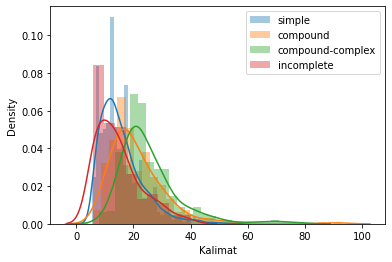

In [88]:
sns.distplot(x_train_sentence_len[simple_sentences], label='simple')
sns.distplot(x_train_sentence_len[compound_sentences], label='compound')
sns.distplot(x_train_sentence_len[compound_complex_sentences], label='compound-complex')
sns.distplot(x_train_sentence_len[incomplete_sentences], label='incomplete')

plt.legend()
plt.show()

In [92]:
for sample_sentence in x_train_structures[incomplete_sentences].head():
    print(sample_sentence)
    print("----")

Paling tidak, menurut Ketua Komisi Pengawas Persaingan Usaha (KPPU), Sutrisno Iwantono.
----
Menikah dengan Niekla Survia Andiesta, mantan penyanyi grup vokal Elfa's Singers, pada tahun 1991 dan dikarunia dua orang anak.
----
Pesepak bola yang bertinggi badan 183 cm.
----
Di masa sekarang biasanya ditambahkan pula dengan selendang untuk melengkapi kecantikan dari busana ini.
----
Ikan air tawar, pemangsa ikan kecil dan krustasea, dewasa berukuran 1,5–7 kg, dengan ciri khas ikan berpunggung pisau: punggungnya meninggi sehingga bagian perut tampak lebar dan pipih.
----


In [55]:
for sample_sentence in x_train_structures[simple_sentences].head():
    print(sample_sentence)
    print("----")

Sulit dimungkiri, sukses Arifin lantaran didukung bekas teman-temannya sesama alumni ITB yang duduk di pemerintahan, seperti eks Menteri Pertambangan dan Energi Ginanjar Kartasasmita dan bekas Menteri Perumahan Rakyat dan Transmigrasi Siswono Yudhohusodo.
----
Bagaimanapun, ia mesti menyelamatkan rapornya dalam pertanggungjawaban di depan MPR Agustus nanti.
----
Daerah industri rumah tangga banyak terdapat mutih kulon, kendalasem, tedunan, kedung karang, babalan, berahan wetan, kedung mutih, bungo dan jungsemi.
----
Fakta ini dibenarkan Munir dari LSM Imparsial.
----
MPR/DPR terbentuk dari hasil rekayasa.
----


In [56]:
for sample_sentence in x_train_structures[compound_sentences].head():
    print(sample_sentence)
    print("----")

Tapi, hampir seratus hari berlalu, toh Azahari dan Noordin tetap lolos.
----
Arifin mengangkat dan membolak-balik roket itu dengan tangan kanannya sambil mendekatkan wajahnya ke roket.
----
Pada event tersebut, ia melewati tiga petinju hebat, yakni dari India dengan RSC, kemudian melibas petinju Jepang, dan terakhir menumbangkan petinju Korea Selatan di partai final yang memberinya medali emas.
----
Wakil Presiden Direktur Artha Graha Wisnu Tjandra tak mengangkat telepon dan tak membalas pesan pendek yang dikirimkan ke telepon selulernya.
----
Di Malaysia karya Tengku Amir Hamzah sudah masuk dalam kurikulum wajib pendidikan mulai tingkat dasar hingga universitas, kata Kepala Museum Langkat itu kepada wartawan dalam rangka Peringatan 100 Tahun Tengku Amir Hamzah 28 Februari 1911 – 28 Februari 2011 di Medan.
----


In [76]:
for sample_sentence in x_train_structures[compound_complex_sentences].head():
    print(sample_sentence)
    print("----")

Di taman ini orang datang dari pelbagai penjuru dunia, dan New York, sebuah Menara Babil yang gagal, menampilkan, dengan tanpa disengaja, paradoksnya: ia melambangkan modernitas Amerika, yang cenderung menyatukan manusia ke dalam satu bahasa, satu pusat, dengan modal dan media, dan mungkin menghasilkan satu tema percakapan.
----
Meski tidak menyimpulkan bahwa intelijen militer Indonesia telah bekerja sama dengan JI, keduanya dikaitkan karena sama-sama menentang Gerakan Aceh Merdeka (GAM).
----
Kambing merupakan anggota dari keluarga Bovidae dan bersaudara dengan biri-biri karena keduanya tergolong dalam sub famili Caprinae.
----
"Malu kita mengaku sebagai negara hukum, KUHP-nya belum diperbarui," kata Jimly Asshiddiqie, seorang ahli hukum tata negara yang kini menjadi Ketua Komisi Konstitusi.
----
Satu salinan surat resmi yang diperoleh Tempo News Room jelas menyebut KONI sudah bekerja sama dengan Magnum Investment Limited, perusahaan investasi milik bandar lotere terbesar Malaysia, Ma

In [173]:
vectorizer = TfidfVectorizer(tokenizer=lambda s: s, lowercase=False)
features_structures = vectorizer.fit_transform(x_train_tokenized)
features_structures = hstack((features_structures, x_train_sentence_len.values.reshape(-1, 1)))

classifier = RandomForestClassifier()

In [174]:
classifier.fit(features_structures, y_train_structures)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [178]:
test_features_structures = vectorizer.transform(x_test_tokenized)
test_features_structures = hstack((test_features_structures, x_test_tokenized.apply(lambda s: len(s)).values.reshape(-1, 1)))

In [179]:
print(
    classification_report(
        y_test_structures, 
        classifier.predict(test_features_structures), 
        target_names=y_structure_columns))

                           precision    recall  f1-score   support

          simple sentence       0.83      0.98      0.89       832
        compound sentence       0.00      0.00      0.00        79
compound-complex sentence       1.00      0.08      0.15        98
      incomplete sentence       0.00      0.00      0.00        31

                micro avg       0.83      0.79      0.81      1040
                macro avg       0.46      0.26      0.26      1040
             weighted avg       0.75      0.79      0.73      1040
              samples avg       0.79      0.79      0.79      1040



# By Predicate & By Intonation

Predicates 

In [5]:
noun_predicate = X_train["Noun-predicate sentence"]
adjective_predicate = X_train["Adjective-predicate sentence"]
prepositional_predicate = X_train["Prepositional phrase-predicate sentence"]


In [13]:
X_train_predicate = X_train[
    (noun_predicate & ~adjective_predicate & ~prepositional_predicate) |
    (~noun_predicate & adjective_predicate & ~prepositional_predicate) |
    (~noun_predicate & ~adjective_predicate & prepositional_predicate) 
].copy()

In [16]:
X_train_predicate[prepositional_predicate].shape

/home/arie/miniconda3/envs/seacorenlp/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(91, 23)